In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import string

In [ ]:
df=pd.read_csv('Restaurant_Reviews.tsv',delimiter='\t',quoting=3)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<Axes: ylabel='count'>

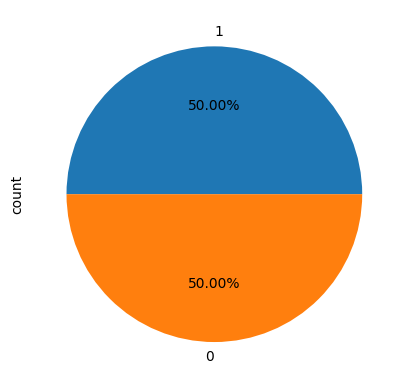

In [ ]:
df['Liked'].value_counts().plot(kind='pie',autopct='%.2f%%')

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def text_preprocess(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    tokens=word_tokenize(text.lower())
    ps=PorterStemmer()
    tokens=[word for word in tokens if word not in string.punctuation]
    new_text=[]
    all_stopwords=stopwords.words("english")
    all_stopwords.remove("not")
    for word in tokens:
        if word in all_stopwords:
            new_text.append('')
        else:
            new_text.append(word)

    stemmed_tokens=[ps.stem(word) for word in new_text]

    return " ".join(stemmed_tokens)

In [ ]:
df["Processed Reviews"]=df["Review"].apply(text_preprocess)

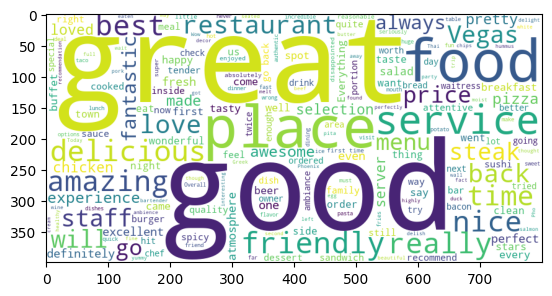

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
positive=df.loc[df['Liked']==1,'Review']
negative=df.loc[df['Liked']==0,'Review']
all_positive_review=' '.join(positive)
all_negative_review=' '.join(negative)
wordcloud_pos=WordCloud(width=800,height=400,background_color='white').generate(all_positive_review)
wordcloud_neg=WordCloud(width=800,height=400,background_color='white').generate(all_negative_review)
plt.imshow(wordcloud_pos)

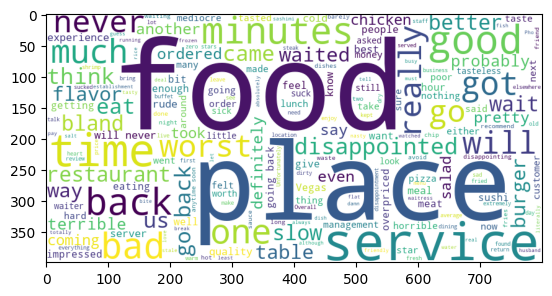

In [ ]:
plt.imshow(wordcloud_neg)

In [ ]:
tfidf=TfidfVectorizer(max_features=1500)
X=tfidf.fit_transform(df['Processed Reviews']).toarray()
y=df['Liked']

In [ ]:
combined_df = pd.DataFrame(X, columns=tfidf.get_feature_names_out())
combined_df['Liked'] = y

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
models = {
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]}),
    'GaussianNB': (GaussianNB(), {'var_smoothing': [0.1,0.01,6,7,8]}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}),
    # 'RandomForestClassifier':(RandomForestClassifier(), {'n_estimators':[50,100,200,500],'max_depth':[None,5,10]}),
    'MultinomialNB':(MultinomialNB(), {'alpha':[0.001,0.1,1,10,100]}),
    # 'KNeighborsClassifier':(KNeighborsClassifier(),{'n_neighbors':[1,3,5,7,10]})
}

for model_name,(model,param_grid) in models.items():
    grid_search=GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
    grid_search.fit(X,y)
    print("Best parameters for", model_name, ":", grid_search.best_params_)
    print("Best score for", model_name, ":", grid_search.best_score_)

Best parameters for SVC : {'C': 1, 'gamma': 0.1}
Best score for SVC : 0.8039999999999999
Best parameters for GaussianNB : {'var_smoothing': 7}
Best score for GaussianNB : 0.7739999999999999
Best parameters for LogisticRegression : {'C': 1, 'solver': 'liblinear'}
Best score for LogisticRegression : 0.8030000000000002
Best parameters for MultinomialNB : {'alpha': 1}
Best score for MultinomialNB : 0.7849999999999999


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score  # Import additional metrics as needed

import seaborn as sns  # Assuming Seaborn is imported for visualizations
import matplotlib.pyplot as plt  # Assuming Matplotlib is imported for visualizations


# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

def evaluate_model(model, X, y, cv):

    scores = []
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Consider using different metrics based on your problem
        score = accuracy_score(y_val, y_pred)
        scores.append(score)


    return scores

def plot_graphs(model):
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # print(f"Confusion matrix for {model.__class__.__name__}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        # print("For k fold : {}")
        plt.figure(figsize=(2,2))


        sns.heatmap(confusion_matrix(y_val,y_pred), annot=True)

        # plt.show()

        # print(f"ROC AUC Curve for {model.__class__.__name__}")
        plt.figure(figsize=(3,3))
        fpr,tpr,threshold=roc_curve(y_val,y_pred)
        plt.plot([0, 1], [0, 1])
        plt.plot(fpr,tpr)

def calc_plot(model):
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Consider using different metrics based on your problem
        # print(f"Classification report for k fold : {i}")
        print(classification_report(y_val,y_pred))

# Create models with potentially improved hyperparameters (you can tune these)
gnb = GaussianNB(var_smoothing=7.0)  # Experiment with different smoothing values
lr = LogisticRegression(C=1, solver='lbfgs')  # Experiment with different C and solver settings
svc = SVC(kernel='linear', gamma=0.1)  # Experiment with different gamma values
mnb = MultinomialNB(alpha=1)  # Experiment with different alpha values

# Perform cross-validation and collect scores
cv = KFold(n_splits=5, shuffle=True, random_state=42)

gnb_scores = evaluate_model(gnb, X, y, cv)
lr_scores = evaluate_model(lr, X, y, cv)
svm_scores = evaluate_model(svc, X, y, cv)
mnb_scores = evaluate_model(mnb, X, y, cv)



mean_score=sum(gnb_scores)/len(gnb_scores)
std_dev = np.std(gnb_scores)

mean_lr_score=sum(lr_scores)/len(lr_scores)
std_lr_dev = np.std(lr_scores)

mean_svm_score=sum(svm_scores)/len(svm_scores)
std_svm_dev = np.std(svm_scores)

mean_mnb_score=sum(mnb_scores)/len(mnb_scores)
std_mnb_dev = np.std(mnb_scores)

print("Cross-validation scores for gaussian Naive Bayes:", gnb_scores)
print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_score, std_dev * 2))

print("Cross-validation scores for logistic regression:", lr_scores)
print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_lr_score, std_lr_dev * 2))

print("Cross-validation scores for SVM scores:", svm_scores)
print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_svm_score, std_svm_dev * 2))

print("Cross-validation scores for multinomial Naive Bayes:", mnb_scores)
print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_mnb_score, std_mnb_dev * 2))


Cross-validation scores for gaussian Naive Bayes: [0.78, 0.7, 0.81, 0.735, 0.82]
Mean accuracy: 0.77 (+/- 0.09)

Cross-validation scores for logistic regression: [0.765, 0.79, 0.87, 0.82, 0.83]
Mean accuracy: 0.82 (+/- 0.07)

Cross-validation scores for SVM scores: [0.78, 0.77, 0.845, 0.775, 0.82]
Mean accuracy: 0.80 (+/- 0.06)

Cross-validation scores for multinomial Naive Bayes: [0.765, 0.805, 0.855, 0.77, 0.84]
Mean accuracy: 0.81 (+/- 0.07)



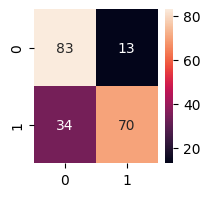

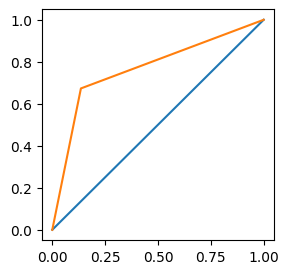

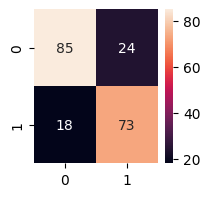

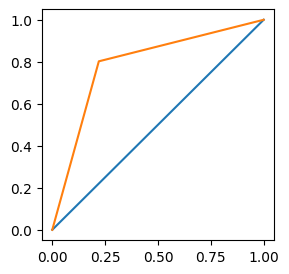

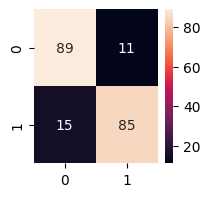

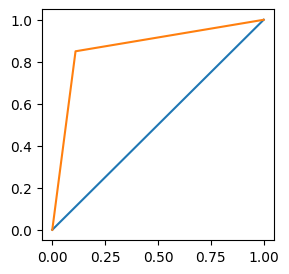

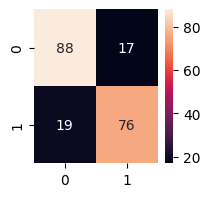

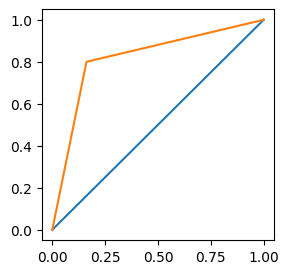

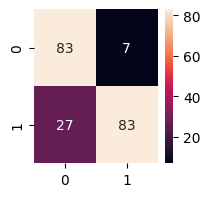

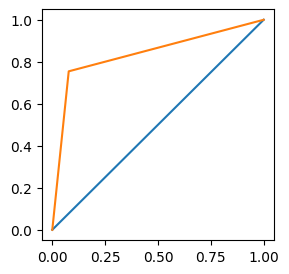

In [ ]:
plot_graphs(lr)

In [ ]:
calc_plot(lr)

              precision    recall  f1-score   support

           0       0.71      0.86      0.78        96
           1       0.84      0.67      0.75       104

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.76       200
weighted avg       0.78      0.77      0.76       200

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       109
           1       0.75      0.80      0.78        91

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       100
           1       0.89      0.85      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200

              preci

In [ ]:

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC



# gnb=GaussianNB(var_smoothing=7)
# lr=LogisticRegression(C=1,solver='liblinear')
# svc=SVC(kernel='linear',gamma=0.1,C=1)
# mnb=MultinomialNB(alpha=1)

# gnb_scores=[]
# lr_scores=[]
# svm_scores=[]
# mnb_scores=[]

# kfold=KFold(n_splits=5,shuffle=True,random_state=42)
# for train_idx,val_idx in kfold.split(X):
#     X_train,X_val=X[train_idx],X[val_idx]
#     y_train,y_val=y[train_idx],y[val_idx]

#     gnb.fit(X_train,y_train)
#     lr.fit(X_train,y_train)
#     svc.fit(X_train,y_train)
#     mnb.fit(X_train,y_train)

#     y_pred=gnb.predict(X_val)
#     y_lr_pred=lr.predict(X_val)
#     y_svm_pred=svc.predict(X_val)
#     y_mnb_pred=mnb.predict(X_val)

#     gnb_score=accuracy_score(y_val,y_pred)
#     lr_score=accuracy_score(y_val,y_lr_pred)
#     svm_score=accuracy_score(y_val,y_svm_pred)
#     mnb_score=accuracy_score(y_val,y_svm_pred)

#     gnb_scores.append(gnb_score)
#     lr_scores.append(lr_score)
#     svm_scores.append(svm_score)
#     mnb_scores.append(mnb_score)

#     print("Confusion matrix for Gaussian Naive Bayes:")
#     sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)
#     plt.show()

#     print("Confusion matrix for Logistic Regression:")
#     sns.heatmap(confusion_matrix(y_val, y_lr_pred), annot=True)
#     plt.show()

#     print("Confusion matrix for Support Vector Machine:")
#     sns.heatmap(confusion_matrix(y_val, y_svm_pred), annot=True)
#     plt.show()

#     print("Confusion matrix for Multinomial Naive Bayes:")
#     sns.heatmap(confusion_matrix(y_val, y_mnb_pred), annot=True)
#     plt.show()
# mean_score=sum(gnb_scores)/len(gnb_scores)
# std_dev = np.std(gnb_scores)

# mean_lr_score=sum(lr_scores)/len(lr_scores)
# std_lr_dev = np.std(lr_scores)

# mean_svm_score=sum(svm_scores)/len(svm_scores)
# std_svm_dev = np.std(svm_scores)

# mean_mnb_score=sum(mnb_scores)/len(mnb_scores)
# std_mnb_dev = np.std(mnb_scores)

# print("Cross-validation scores:", gnb_scores)
# print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_score, std_dev * 2))

# print("Cross-validation scores:", lr_scores)
# print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_lr_score, std_lr_dev * 2))

# print("Cross-validation scores:", svm_scores)
# print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_svm_score, std_svm_dev * 2))

# print("Cross-validation scores:", mnb_scores)
# print("Mean accuracy: %0.2f (+/- %0.2f)\n" % (mean_mnb_score, std_mnb_dev * 2))




In [ ]:
# sum(lr_train_scores)/len(lr_train_scores)
#


In [ ]:
# from sklearn.model_selection import cross_val_score
# cv=KFold(n_splits=5,shuffle=True,random_state=42)
# print(cross_val_score(gnb,X,y,cv=cv,scoring='accuracy').mean())